In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Problem definition: 
##Then "insinkable" Giantic ship Titanic hit icebery during her mainden voyage in 1912. Due to insufficient life boats, the tragedy led to
##massive claim of lives. The competion is to predict whether he/she can survive based on the provided data. 

#Goal of this project: Optimize data processing to imporve base model prediction, stacking base model predictions to enhancing overall prediction.

#Load data and combine train/test data for unbiased processing
data_train= pd.read_csv('train.csv')
data_test= pd.read_csv('test.csv')
data_all= pd.concat([data_train, data_test])
data_all = data_all.drop(['Survived'], axis=1)
m_train = data_train.shape[0]
m_test = data_test.shape[0]
data_all.shape, data_train.shape, data_test.shape

((1309, 11), (891, 12), (418, 11))

In [338]:
#Part 1. Data preview and cleanning
#1.1 Preview data by statistics
#1.1.1 Raw data preview
data_all.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,373450


In [339]:
#data types of each column
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [340]:
#1.1.2 Numerical data statistics
data_all.describe() #Strictly speaking, Pclass should be classified as ordinal.
  #Continuous: Age and Fare; Discrete: Parch, SibSp and Pclass (if classified as numerical)

,Age,Fare,Parch,PassengerId,Pclass,SibSp
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000


In [341]:
data_train.describe()
  #Including Survived: 38% people survived during this tragedy.
  #Comparing data_train and data_all, they are very homogenerous in Pclass, Age, Fare, SibSp, and Parch based on mean and stdev.
  #Thus, the training data may well represent the whole dataset.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [342]:
#1.1.3 Categorical data statistics
data_all.describe(include=['O'])
  #Name and Ticket: >99% uniqueness, raw values useless for ML. #Cabin: 14% uniqueness, can we narrow it down?

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343
freq,6,914,2,843,11


In [343]:
#1.2 Explore missing data in each column

data_all.isnull().sum()  
  #Results: Age 263; Cabin 1014; Embarked 2; Fare 18.
    
# There is only one row showing Fare.isnull. Are there any rows showing Fare==0?
data_all[data_all['Fare']==0].count()
  #Results: Fare==0 having 17 rows. Thus, in total, there are 18 rowing missing Fare values.

#Age: 
data_all[data_all['Age']==0].count()
  #Results: 0 rows (BTW, age==0 could be a valid data).

Age            0
Cabin          0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Ticket         0
dtype: int64

In [344]:
#1.3. Impute missing data: including pre-processing raw data for imputing missing values in Columns of Embarked, Age and Cabin.

#1.3.1. Missing Fare: intuitively, fare is largely proportional to Pclass, thus, impute the missing fare with mean values of the corresponding Pclass
data_all.loc[data_all['Fare']==0, 'Fare'] = np.nan
data_all['Fare'] = data_all.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))


#The missing values in Embarked, Age and Cabin: no clear-cut ways to impute, will impute based on RandomForest
#To pre-process the raw data in order to run RandomForest for data imputing.

#1.3.2.Data preprocessing: define functions to preprocess raw data and extract hidden features from raw data

#Given >14% uniqueness in raw data, can we simplify them by only taking the first letter or number from cabins?
def Simplify_cabins(data):
    data.Cabin = data.Cabin.fillna('N')
    data.Cabin = data.Cabin.apply(lambda x: x[0])
    return data

#Extract name suffix from name.
def NameSuffix(data):
    data['LastName'] = data['Name'].apply(lambda x: x.split(',')[0])
    data['FirstName'] = data['Name'].apply(lambda x: x.split(',')[1])
    data['NameSuffix'] = data['FirstName'].apply(lambda x: x.split('.')[0])
    return data

def Encode_features(data, features):
    for feature in features:
        data[feature] = data[feature].fillna(0)
        le = preprocessing.LabelEncoder().fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data

def Feature_preprocess(data):
    data = NameSuffix(data)
    data = Simplify_cabins(data)
    data = Encode_features(data, ['Cabin', 'Embarked',  'Sex'])
    return data

data_all = Feature_preprocess(data_all)
data_train = Feature_preprocess(data_train) #for later visualization

#Simplify name suffix: suffix with less than 10 counts simplified based sex, family size, and sociental class.
namesuffix = {' Col': 'Rare', ' Don': 'Rare', ' Mme': 'Mrs', ' Major': 'Rare', ' Lady': 'Mrs', ' Sir': 'Mr', 
              ' Mlle': 'Miss', ' the Countess': 'Mrs', ' Jonkheer': 'Rare', ' Capt': 'Rare', ' Mr': 'Mr', ' Mrs': 'Mrs',
             ' Miss': 'Miss', ' Master': 'Master', ' Rev': 'Rare', ' Dr': 'Rare', ' Ms': 'Miss', ' Dona': 'Mrs'}
data_all["NameSuffix"] = data_all["NameSuffix"].map(namesuffix)
data_train['NameSuffix'] = data_train['NameSuffix'].map(namesuffix)

data_all.loc[(data_all['NameSuffix']=='Rare')&(data_all['Sex']==0), 'NameSuffix'] = 'Mrs' #Explain in the 2.3 EDA
data_train.loc[(data_train['NameSuffix']=='Rare')&(data_train['Sex']==0), 'NameSuffix'] = 'Mrs'

#Add features FamilySize by combining 'SibSp' and 'Parch'
data_all['FamilySize'] = data_all['SibSp'] + data_all['Parch'] + 1


#1.3.3. Missing Embarked: imputing the missing Embarked by RandomForest
data_embarked = data_all[['Embarked', 'Fare', 'Pclass', 'FamilySize']]

data_embarked_exist = data_embarked.loc[(data_embarked.Embarked!=0)]
data_embarked_null = data_embarked.loc[(data_embarked.Embarked==0)]
x_embarked = data_embarked_exist.iloc[:, 1:]
y_embarked = data_embarked_exist.iloc[:, 0]
rfc_e = RandomForestClassifier(n_estimators=100)
rfc_e.fit(x_embarked, y_embarked)
y_embarked_hat = rfc_e.predict(data_embarked_null.iloc[:, 1:])
data_all.loc[data_all.Embarked==0, 'Embarked'] = y_embarked_hat

#1.3.4. Missing Age: imputing the missing Age by RandomForest

data_all_imputer = data_all.drop(['Name', 'Ticket', 'SibSp', 'Parch', 'LastName', 'FirstName'], axis=1)
data_all_imputer = pd.get_dummies(data_all_imputer)

data_age = data_all_imputer[['Age', 'Pclass', 'Sex', 'Fare', 'FamilySize', 'NameSuffix_Master', 'NameSuffix_Miss', 'NameSuffix_Mrs', 'NameSuffix_Mr', 'NameSuffix_Rare']]
data_age_exist = data_age.loc[(data_all.Age.notnull())]
data_age_null = data_age.loc[(data_all.Age.isnull())]
x_age = data_age_exist.values[:, 1:]
y_age = data_age_exist.values[:, 0]

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(x_age, y_age)
y_hat_age = rfr.predict(data_age_null.values[:,1:])
data_all.loc[(data_all.Age.isnull()), 'Age'] = y_hat_age
data_all_imputer.loc[(data_all_imputer.Age.isnull(), 'Age')] = y_hat_age

#1.3.5. Missing Cabin: imputing the missing Cabin by RandomForest
data_cabin = data_all_imputer[['Cabin', 'Pclass', 'Sex', 'Fare', 'FamilySize', 'Embarked', 'Age', 'NameSuffix_Master', 'NameSuffix_Miss', 'NameSuffix_Mrs', 'NameSuffix_Mr', 'NameSuffix_Rare']]
data_cabin_exist = data_cabin.loc[(data_cabin.Cabin!=7)]
data_cabin_null = data_cabin.loc[(data_cabin.Cabin==7)]
x_cabin = data_cabin_exist.iloc[:, 1:]
y_cabin = data_cabin_exist.iloc[:, 0]
rfc_c = RandomForestClassifier(n_estimators=100)
rfc_c.fit(x_cabin, y_cabin)
y_cabin_hat = rfc_c.predict(data_cabin_null.iloc[:, 1:])
data_all.loc[data_all.Cabin==7, 'Cabin'] = y_cabin_hat

data_all.loc[data_all['Cabin']==8,'Cabin'] = data_all['Cabin'].mode()[0]

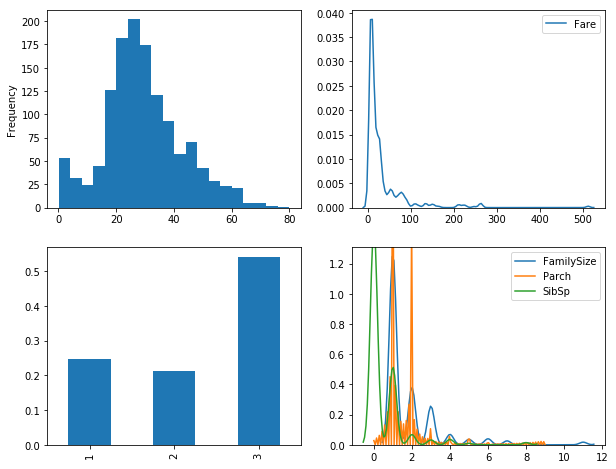

In [345]:
#2. Exploratory Data Analysis
#2.1 EDA by Visualization: feature distribution

fig, ax = plt.subplots(2,2,figsize=(10,8))
data_all['Age'].plot.hist(bins=20, ax=ax[0][0])
sns.kdeplot(data_all['Fare'], ax=ax[0][1])
(data_all['Pclass'].value_counts()/len(data_all['Pclass'])).sort_index().plot.bar(ax=ax[1][0])
sns.kdeplot(data_all['FamilySize'], ax=ax[1][1])
sns.kdeplot(data_all['Parch'],  ax=ax[1][1])
sns.kdeplot(data_all['SibSp'],  ax=ax[1][1])
#Note: FamilySize, Parch and SibSp should take discrete values.
#Fare and FamilySize are skewed with most of them distributing in the low values. Most of passengers were between 20-45 years old. And Class 3 has over 50% passengers.

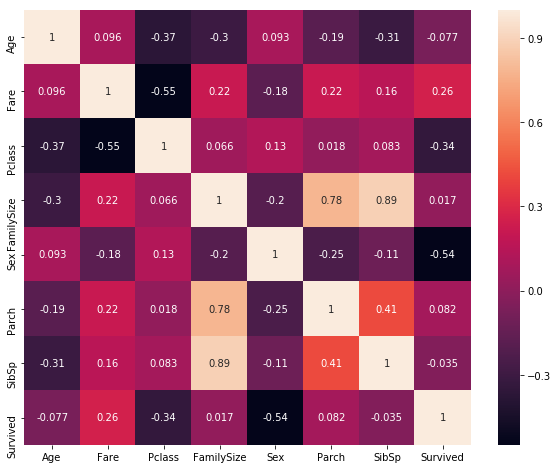

In [346]:
#2.2 EDA by visualization: features correlation - numerical features
data_train['FamilySize'] = data_train['Parch'] + data_train['SibSp'] + 1
plt.figure(figsize=(10,8))
sns.heatmap(data_train.loc[:, ['Age', 'Fare', 'Pclass', 'FamilySize', 'Sex', 'Parch', 'SibSp', 'Survived']].corr(),annot=True)

#(Fare and Pclass has strong correlation with survival; as expected Fare and Pclass well correlated; Age and Pclass also has some correlation: the older the richer?)

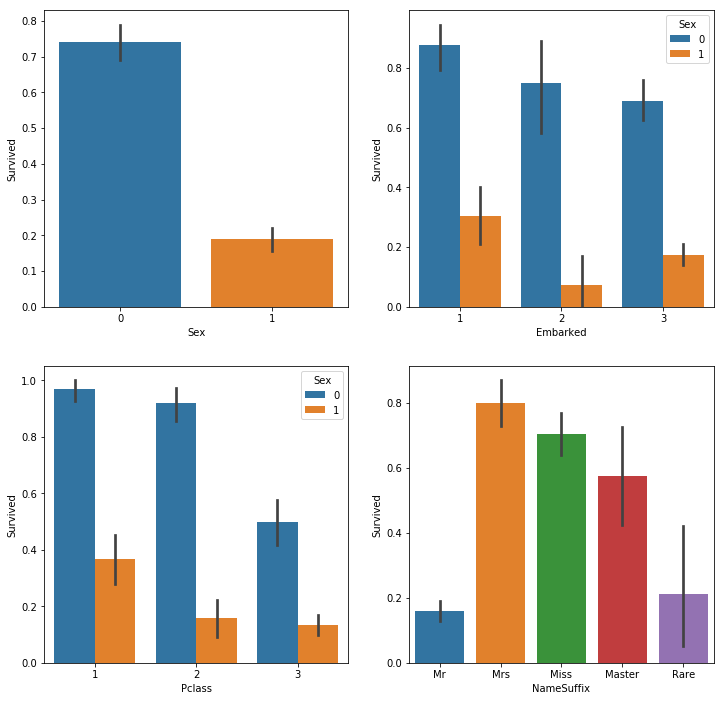

In [347]:
#2.3 EDA by visualization: feature correlations with Survival - categorical features

fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.barplot(x='Sex', y='Survived', data=data_train, ax=ax[0][0])
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=data_train.loc[data_train['Embarked']!=0,:], ax=ax[0][1])
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=data_train, ax=ax[1][0])
sns.barplot(x='NameSuffix', y='Survived', data=data_train, ax=ax[1][1])

#（Female has around 4 times higher survival rate; Embarked at C has higher survival rate for both male and female?; The higher the class, the lower the survival rate.）

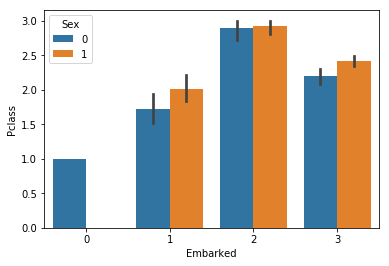

In [348]:
#Intuitively Embarked should not have strong correlation with Survival, yet Embarked at C shows higher survival for male than others.
sns.barplot(x='Embarked', y='Pclass', hue='Sex', data=data_train)
##Embarked at C shows lowest Pclass, suggesting that it is likely the Pclass distribution resulting in higher survival rate in C and not necessarily Embarked itself resulting in higher Survival rate.

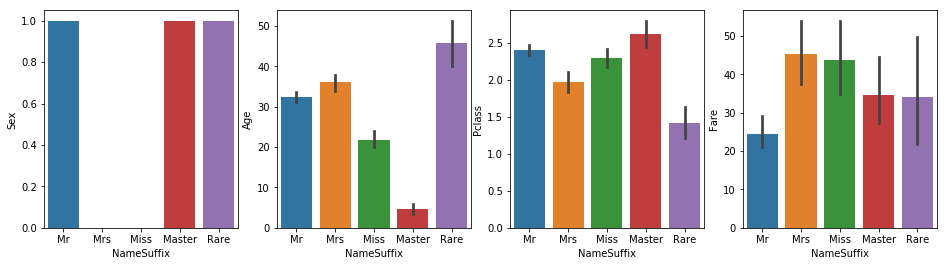

In [349]:
#Understand NameSuffix correlation
#NameSuffix reflects sex, age and societal class. Given sex, age and pclass all showing strong correlation with survival, their aggregation may shine light on prediction.
fig, ax = plt.subplots(1,4,figsize=(16,4))

sns.barplot(x='NameSuffix', y='Sex', data=data_train,ax=ax[0])
sns.barplot(x='NameSuffix', y='Age', data=data_train, ax=ax[1])
sns.barplot(x='NameSuffix', y='Pclass', data=data_train, ax=ax[2])
sns.barplot(x='NameSuffix', y='Fare', data=data_train, ax=ax[3])

##NOTE1: Given that there is only one female with namesuffix falling at Rare in data_train (not in data_test) and survived 
#and the highest survival rate with Mrs and coupled with her age, the namesuffix of this data row will be assigned to Mrs.
##NOTE2: Female urvival rate Mrs >Miss likely due to higher societal class and older age.
##NOTE3: Male survival rate Master > Rare > Mr suggests Age plays the most important role followed by age and societal class given that
#Rare suffix are mostly honorable and credited to senior people.

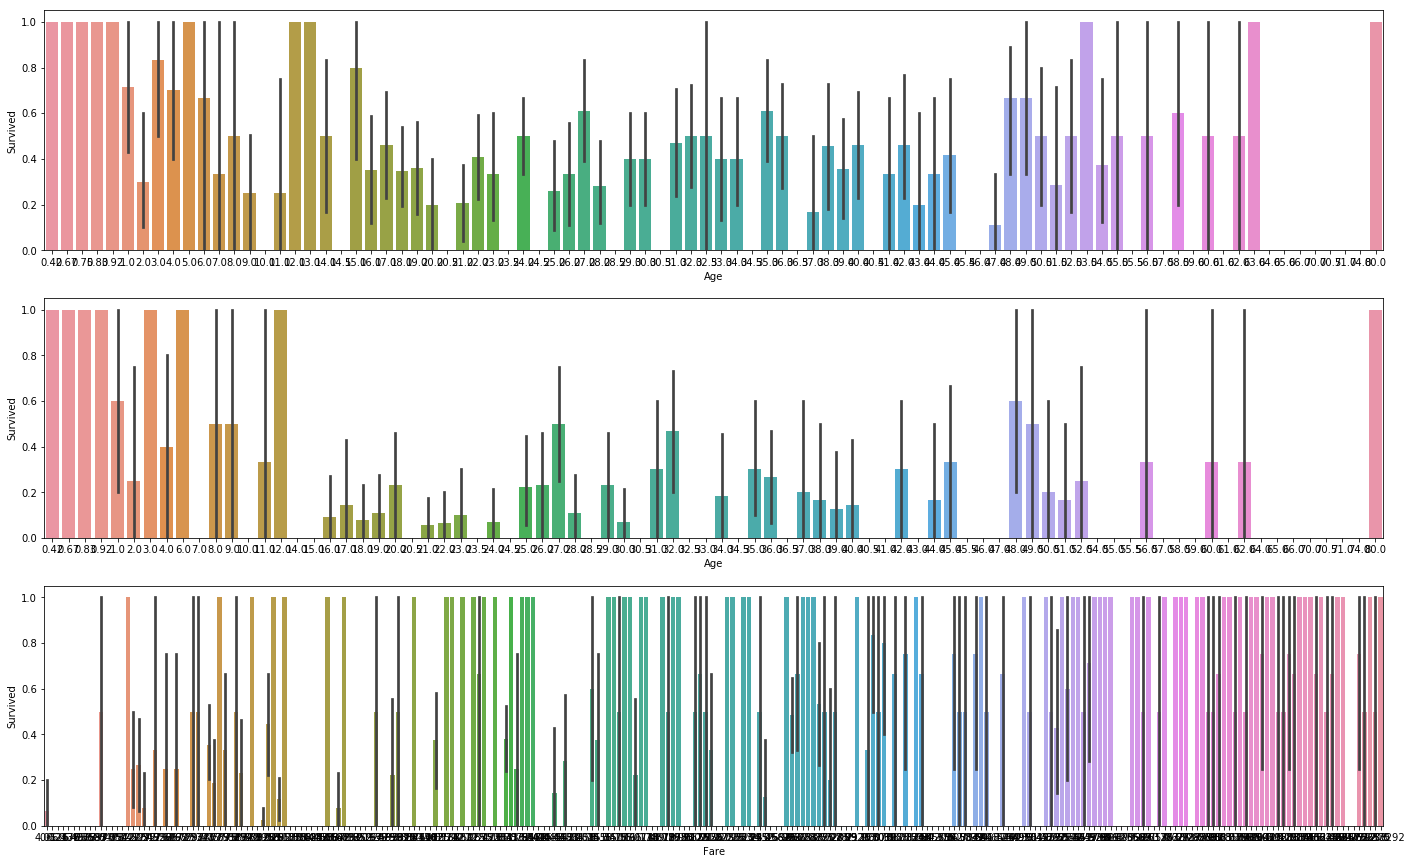

In [352]:
#2.4 EDA by visualization: More on feature correlation with Survival - for partitioning the numeric features 
fig, arr = plt.subplots(3,1,figsize=(24,15))
sns.barplot(x='Age', y='Survived', data=data_train, ax=arr[0])
sns.barplot(x='Age', y='Survived', data=data_train[data_train['Sex']==1], ax=arr[1])
sns.barplot(x='Fare', y='Survived', data=data_train, ax=arr[2])

#(Age <5 and Age > 55 have higher survival rate; The higher the fare, the higher the survival rate.)

In [ ]:
##General understanding from EDA by statistics and visualization: 
#There are patterns (features) establishing relationship with survival rate such as Sex, Age, Pclass, and Fare (these features to be used in modeling).
#Age and Fare are continuous numeric features that need to be partitioned to augment their effect.
#Cabins, Name (first, last and suffix), FamilySize,etc. need to be further explored.

In [353]:
#3. Features transform for classification algorithm and select features for modeling
#3.1 Feature transformation
def BinAges(data):
    bins=(0,5,14,22,30,55,100)
    group_names=["Baby", "Children","Teenage", "Young Adult", "Adult", "Senior"]
    categories = pd.cut(data.Age, bins, labels=group_names)
    data.Age=categories
    return data

def BinFares(data):
    bins = (0,7.9,14.4,31,1000)
    group_names=['1_q', '2_q', '3_q', '4_q']
    categories = pd.cut(data.Fare, bins, labels=group_names)
    data.Fare = categories
    return data

def BinFamilySize(data):
    bins = (0,1,2,4,11)
    group_names=['Alone', 'Couple', 'Three-Four', 'Group']
    categories=pd.cut(data.FamilySize, bins, labels=group_names)
    data.FamilySize=categories
    return data

def transform_feature(data):
    data = BinAges(data)
    data = BinFares(data)
    data = BinFamilySize(data)
    return data
 
data_all = transform_feature(data_all)

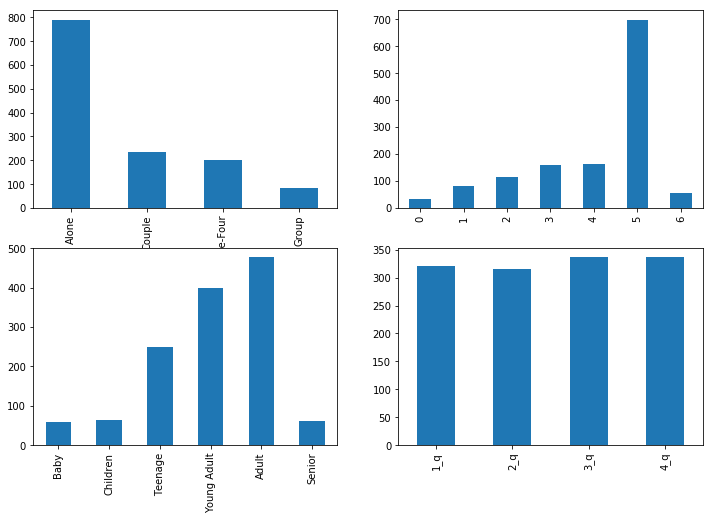

In [355]:
#3.2.1 Visualization after feature transformation: statistics
fig, ax = plt.subplots(2,2,figsize=(12,8))
data_all['FamilySize'].value_counts().plot.bar(ax=ax[0][0])
data_all['Cabin'].value_counts().sort_index().plot.bar(ax=ax[0][1]) #RF predicts most of the missing Cabin to 5.
data_all['Age'].value_counts().sort_index().plot.bar(ax=ax[1][0])
data_all['Fare'].value_counts().sort_index().plot.bar(ax=ax[1][1])

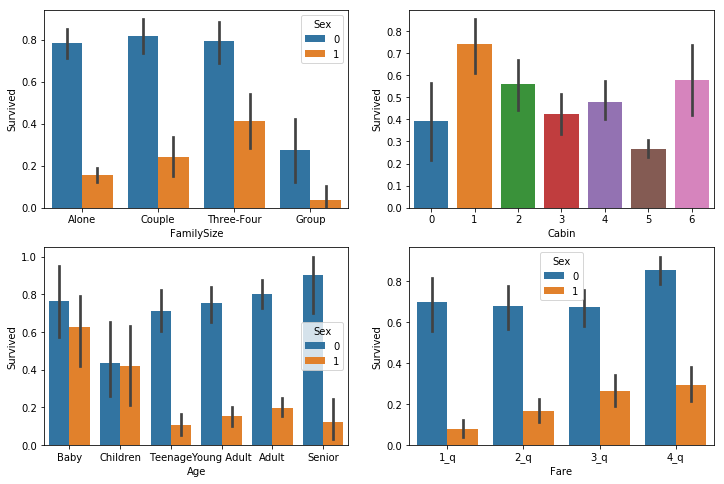

In [357]:
#3.2.2 Visualization: correlation b/t binned categorical data and Survived using training data

data_train_preML_x = data_all.iloc[:m_train]
data_train_preML = pd.merge(data_train_preML_x, data_train[['Survived', 'PassengerId']], how='left', on='PassengerId')
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.barplot(x='FamilySize', y='Survived', hue='Sex', data=data_train_preML, ax=ax[0][0])
sns.barplot(x='Cabin', y='Survived', data=data_train_preML, ax=ax[0][1])
sns.barplot(x='Age', y='Survived', hue='Sex', data=data_train_preML, ax=ax[1][0])
sns.barplot(x='Fare', y='Survived', hue='Sex', data=data_train_preML, ax=ax[1][1])

##General information: female, baby/Senior citizen, higher fare, and mid-sized familysize have more chance of surviving.
##FamilySize to be added; Cabin not strong pattern, to be further explored.

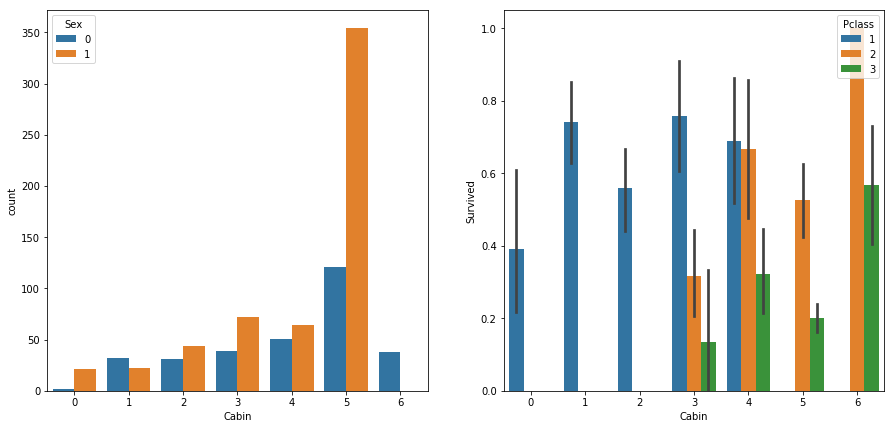

In [358]:
#Cabin: How could 'Cabin' affect survival? Is it a contributing feature or just because of non-uniform distribution from strong features.

fig, ax = plt.subplots(1,2, figsize=(15,7))

sns.countplot(x='Cabin',hue='Sex', data=data_train_preML, ax=ax[0])
sns.barplot(x='Cabin', y='Survived', hue='Pclass', data=data_train_preML, ax=ax[1])

##Unbalanced distribution in both Sex and Pclass in Cabin categories. Given the strong dependence on Sex and Pclass,
##the feature Cabin may not provide additional information other than that from skewed distributions of Sex and Pclass.

In [361]:
#Select features for ML and Categorical feature transform by OneHotEncoding

#drop features
data_all = data_all.drop(['Ticket', 'Name', 'SibSp', 'Parch', 'FirstName', 'LastName', 'Cabin'], axis=1)

#Encode categorical features
dummy_features = ['Embarked', 'NameSuffix', 'Age', 'Fare', 'FamilySize']

for feature in dummy_features:
    data_all[feature] = data_all[feature].apply(str)

data_all = pd.get_dummies(data_all)

data_all.columns

Index([u'PassengerId', u'Pclass', u'Sex', u'Age_Baby', u'Age_Children',
       u'Age_Teenage', u'Age_Young Adult', u'Age_Adult', u'Age_Senior',
       u'Embarked_1', u'Embarked_2', u'Embarked_3', u'Fare_1_q', u'Fare_2_q',
       u'Fare_3_q', u'Fare_4_q', u'NameSuffix_Master', u'NameSuffix_Miss',
       u'NameSuffix_Mr', u'NameSuffix_Mrs', u'NameSuffix_Rare',
       u'FamilySize_Alone', u'FamilySize_Couple', u'FamilySize_Three-Four',
       u'FamilySize_Group'],
      dtype='object')

In [362]:
#split training data into training and validation sets
x = data_all.iloc[:m_train,:].drop(['PassengerId'], axis=1)
y = data_train['Survived']

data_test = data_all.iloc[m_train:,:].drop(['PassengerId'], axis=1)

num_test = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = num_test, random_state=23)


In [ ]:
#4. Base models: for tuning hyper-parameters and understanding performance of each base model

accuracy_dict = {}

#Logistic Regression
lr = LogisticRegression(C=1e3, penalty='l2', max_iter=100, fit_intercept=False, solver='liblinear',
                        n_jobs=-1, random_state=0)
lr = lr.fit(x_train, y_train)
y_hat_lr = lr.predict(x_test)
accuracy_dict['LogisticRegression'] = accuracy_score(y_test, y_hat_lr)

print lr
print accuracy_dict['LogisticRegression']

#Decision Tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=None, min_samples_split=3, min_samples_leaf=2,
                            random_state=0)

dt = dt.fit(x_train, y_train)
y_hat_dt = dt.predict(x_test)
accuracy_dict['DecisionTree'] = accuracy_score(y_test, y_hat_dt)
print dt
print accuracy_dict['DecisionTree']

#Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, criterion='gini', max_features='sqrt', min_samples_split=2, n_jobs=-1, verbose=1)
# parameters = {'n_estimators':[100,50], 
#               'max_features':['auto'],
#               'criterion': ['gini'],
#               'max_depth': [2,3,5],
#               'min_samples_split': [2,3],
#               'min_samples_leaf': [1,2]
#              } 
# acc_scorer = make_scorer(accuracy_score)

# rfc = GridSearchCV(rfc, parameters, cv=3, scoring = acc_scorer, n_jobs = -1, verbose = 1)
rfc = rfc.fit(x_train, y_train)
print rfc.feature_importances_
y_hat_rfc = rfc.predict(x_test)
accuracy_dict['RandomForest'] = accuracy_score(y_test, y_hat_rfc)
print rfc
print accuracy_dict['RandomForest']

#Extra Tree
et = ExtraTreesClassifier(n_estimators=100, max_features='sqrt', max_depth=5, criterion='gini', random_state=0, n_jobs=-1,verbose=1)

# params = {'n_estimators': [100,1000,10000], 'max_features': ['sqrt', 'log2'], 'max_depth': [2,3,5],
#           'min_samples_split': [2,3,5], 'min_samples_leaf': [1,2,3]}

# et = GridSearchCV(et, params, cv=3, n_jobs=-1, verbose=1)
et=et.fit(x_train, y_train)
#print etc.feature_importances_
y_hat_etc=et.predict(x_test)
accuracy_dict['ExtraTrees'] = accuracy_score(y_test, y_hat_etc)
print et
print accuracy_dict['ExtraTrees']

#Gradient Boosting
gb = GradientBoostingClassifier(learning_rate=0.02, n_estimators=100, max_depth=3, max_features = 'auto', min_samples_split=3, loss='deviance')

# params = {'loss': ['deviance'], 'learning_rate': [0.02, 0.1, 0.2], 'n_estimators': [100, 1000], 'max_depth': [2,3,5],
#           'min_samples_split': [2,3]}
# gb = GridSearchCV(gb, params, cv=3, n_jobs=-1, verbose=1)
gb = gb.fit(x_train, y_train)
#print gbc.feature_importances_
y_hat_gb = gb.predict(x_test)
accuracy_dict['GradientBoosting'] = accuracy_score(y_test, y_hat_gb)
print gb
print accuracy_dict['GradientBoosting']

#AdaBoost
ada = AdaBoostClassifier(learning_rate=0.2, n_estimators=500, random_state=0)
ada = ada.fit(x_train, y_train)
#print ada.feature_importances_
y_hat_ada = ada.predict(x_test)

accuracy_dict['AdaBoost'] = accuracy_score(y_test, y_hat_ada)
print ada
print accuracy_dict['AdaBoost']

#SVM
svc = SVC(kernel='rbf', gamma='auto', C=1)

svc = svc.fit(x_train, y_train)

y_hat_svc = svc.predict(x_test)

accuracy_dict['SVC'] = accuracy_score(y_test, y_hat_svc)
print svc
print accuracy_dict['SVC']

#XGBoost

xgb = xgb.XGBClassifier(base_score=0.5, max_depth=2, learning_rate=0.6, n_estimators=1000, objective = 'binary:logistic', 
                        booster = 'gbtree', reg_alpha=0.2, reg_lambda=1, random_state=0)
# xgb = xgb.XGBClassifier()
# params = {'max_depth': [2,3,6], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [100,1000], 
#           'objective': ['binary:logistic'], 'booster': ['gbtree'], 'reg_alpha': [0.1, 0.2]}
# xgbc = GridSearchCV(xgbc, params, n_jobs=-1)
xgb = xgb.fit(x_train, y_train)
#print xgb.feature_importances_
y_hat_xgb = xgb.predict(x_test)
accuracy_dict['XGBoost'] = accuracy_score(y_test, y_hat_xgb)
print xgb
print accuracy_dict['XGBoost']

#LightGBM

lgb = lgb.LGBMClassifier('boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 2, 'n_estimators': 100,
             'objective': 'binary', 'random_state': 0)
lgb = lgb.fit(x_train, y_train)
y_hat_lgb = lgb.predict(x_test)
accuracy_dict['LightGBM'] = accuracy_score(y_test, y_hat_lgb)
print lgb
print accuracy_dict['LightGBM']

In [64]:
#5. Base model prediction with K-Fold cross-validation

class BaseModelClassifier(object):
    def __init__(self, clf, seed=0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def fit(self, x, y):
        return self.clf.fit(x,y)
            
    def predict(self, x):
        return self.clf.predict(x)

#parameters for base models
lg_params = {'C':1e3, 'penalty':'l2', 'max_iter':1000, 'fit_intercept':False, 'solver':'liblinear', 'n_jobs': -1, 'random_state':0}

dt_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'random_state': 0}
rf_params = {'n_estimators':100, 'max_depth':5, 'criterion':'gini', 'max_features':'sqrt', 'min_samples_split':2, 
             'n_jobs':-1, 'random_state':0}

gb_params = {'learning_rate':0.02, 'n_estimators':100, 'max_depth':3, 'max_features': 'auto', 'min_samples_split':3, 
             'loss':'deviance', 'random_state': 0}

ada_params = {'learning_rate':0.2, 'n_estimators':500, 'random_state':0}

svm_params = {'kernel':'linear', 'C':1, 'random_state':0}

xgb_params = {'base_score':0.5, 'max_depth':2, 'learning_rate':0.6, 'n_estimators':1000, 'objective': 'binary:logistic', 
                        'booster': 'gbtree', 'reg_alpha':0.2, 'reg_lambda':1, 'random_state':0}
lgb_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 2, 'n_estimators': 100,
             'objective': 'binary', 'random_state': 0}
et_params = {'n_estimators':100, 'max_features':'sqrt', 'max_depth':5, 'criterion':'gini', 'random_state':0}

#K-Fold cross-validation
nfolds = 5
kf = KFold(m_train, n_folds = nfolds, random_state=0)
def OOFold(clf, x_train, y_train, x_test):
    OOF_train = np.zeros((m_train,))
    OOF_test = np.zeros((m_test,))
    OOF_test_kf = np.zeros((nfolds, m_test))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_kf_train = x_train.iloc[train_index]
        y_kf_train = y_train.iloc[train_index]
        
        x_kf_test = x_train.iloc[test_index]
        clf.fit(x_kf_train, y_kf_train)
        
        OOF_train[test_index] = clf.predict(x_kf_test)
        
        OOF_test_kf[i, :] = clf.predict(x_test)
        
    OOF_test_mean = OOF_test_kf.mean(axis=0)
    OOF_test_kf_df = pd.DataFrame(data=OOF_test_kf)
    OOF_test_mode = OOF_test_kf_df.mode(axis=0)
    OOF_test_mode = OOF_test_mode.values

    
    return OOF_train, OOF_test_mean, OOF_test_mode

#define prediction function for base models
def get_oof_prediction(models):
    nrows_train = data_train.shape[0]
    nrows_test = data_test.shape[0]
    oof_train_pred = np.zeros((nrows_train, len(models)))
    oof_test_mean_pred = np.zeros((nrows_test, len(models)))
    oof_test_mode_pred = np.zeros((nrows_test, len(models)))
    for i in range(len(models)):
        model = models[i]
        oof_train_pred[:, i], oof_test_mean_pred[:, i], oof_test_mode_pred[:, i] = OOFold(model, x, y, data_test)
    oof_train_pred = pd.DataFrame(data=oof_train_pred)
    oof_test_mean_pred = pd.DataFrame(data=oof_test_mean_pred)
    oof_test_mode_pred = pd.DataFrame(data=oof_test_mode_pred)
    return oof_train_pred, oof_test_mean_pred, oof_test_mode_pred

#Get prediction based on base models
lg = BaseModelClassifier(LogisticRegression, seed=0, params=lg_params)
dt = BaseModelClassifier(DecisionTreeClassifier, seed=0, params=dt_params)
rf = BaseModelClassifier(RandomForestClassifier, seed=0, params=rf_params)
gb = BaseModelClassifier(GradientBoostingClassifier, seed=0, params=gb_params)
ada = BaseModelClassifier(AdaBoostClassifier, seed=0, params=ada_params)
svm = BaseModelClassifier(SVC, seed=0, params=svm_params)
xgb = BaseModelClassifier(XGBClassifier, seed=0, params=xgb_params)
lgb = BaseModelClassifier(lgb.LGBMClassifier, seed=0, params=lgb_params)
et = BaseModelClassifier(ExtraTreesClassifier, seed=0, params=et_params)

models = [lg, dt, rf, gb, ada, svm, xgb, lgb, et]
        
oof_train, oof_test_mean, oof_test_mode = get_oof_prediction(models)

columns = {0: 'lg',1: 'dt', 2: 'rf', 3: 'gb', 4: 'ada', 5: 'svm', 6: 'xgb', 7: 'lgb', 8: 'et'}
oof_train = oof_train.rename(columns=columns)
oof_test_mean = oof_test_mean.rename(columns=columns)
oof_test_mode = oof_test_mode.rename(columns=columns)

accuracy_base_oof = {}
for col in oof_train.columns.tolist():
    accuracy_base_oof[col]= accuracy_score(y, oof_train[col])

print accuracy_base_oof

{'lg': 0.8125701459034792, 'svm': 0.8013468013468014, 'lgb': 0.8170594837261503, 'xgb': 0.8148148148148148, 'rf': 0.8125701459034792, 'gb': 0.8294051627384961, 'ada': 0.8069584736251403, 'et': 0.8103254769921436, 'dt': 0.813692480359147}


In [27]:
#Base models correlation: to decide which predicted data to be feeded for stacking.
#plotly.tools.set_credentials_file(username='xxxxx', api_key='rGZu418WMZgckbLCiEtm')

data = [go.Heatmap(z=oof_train.astype(float).corr().values,
                  y=oof_train.columns.values,
                  x=oof_train.columns.values,
                  showscale=True)]
py.iplot(data, filename='oof_train_corr')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rzhou1/0 or inside your plot.ly account where it is named 'oof_train_corr'


In [44]:
#6. Stacking the base models
#6.1 LightGBM

lgb = LGBMClassifier(boosting_type='gbdt', objective='binary',random_state=0)

params = {'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [100,500,1000,5000], 'num_leaves': [5,10,31], 
          'max_depth': [2,3,5,8], 'min_child_samples': [3,5,8]}
lgb = GridSearchCV(lgb, params, cv=3, verbose=1, n_jobs=-1)
lgb.fit(oof_train.drop(['ada', 'svm', 'et'], axis=1), y)
y_stack_hat_lgb = lgb.predict(oof_test_mean.drop(['ada', 'svm', 'et'], axis=1))

y_stack_hat_lgb = pd.DataFrame(data=y_stack_hat_lgb)
y_stack_hat_lgb = pd.DataFrame(data={'PassengerId': data_all.iloc[m_train:, 0], 'Survived': y_stack_hat_lgb.iloc[:,0]})
y_stack_hat_lgb.to_csv('sub_stack1_sel5_lgb.csv', index=False)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 525 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  2.8min finished
